# Transfer Learning Neural Network for Multiclass Skin Disease Classification with DenseNet
This notebook will detail our process of creating a Convolutional Neural Network in order to multi-classify skin diseases from image data.

### Import Dependencies

In [1]:
import tensorflow
from tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.6.4
Keras version: 2.6.0


### Training Model via Dedicated GPU

In [2]:
# # Checking if GPU is Registered
# from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())

In [3]:
# print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
# gpus = tensorflow.config.list_physical_devices('GPU')
# tensorflow.config.set_visible_devices(gpus[0], 'GPU')

In [4]:
# gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tensorflow.config.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tensorflow.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)
# print(gpus)
# print(logical_gpus)

In [5]:
# gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tensorflow.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tensorflow.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [7]:
!pip install split_folders

In [8]:
import splitfolders

In [9]:
os.makedirs('output')
os.makedirs('output/train')
os.makedirs('output/val')

loc = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"

splitfolders.fixed(loc,output ="output",fixed = (1000,250,0))

Copying files: 12500 files [01:09, 178.98 files/s]


### Import and Explore the data
We previously done a more extensive data exploration in the Exploratory_Data_Analysis.ipynb file so we will only do some simple data exploration here.

10 classes:
['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


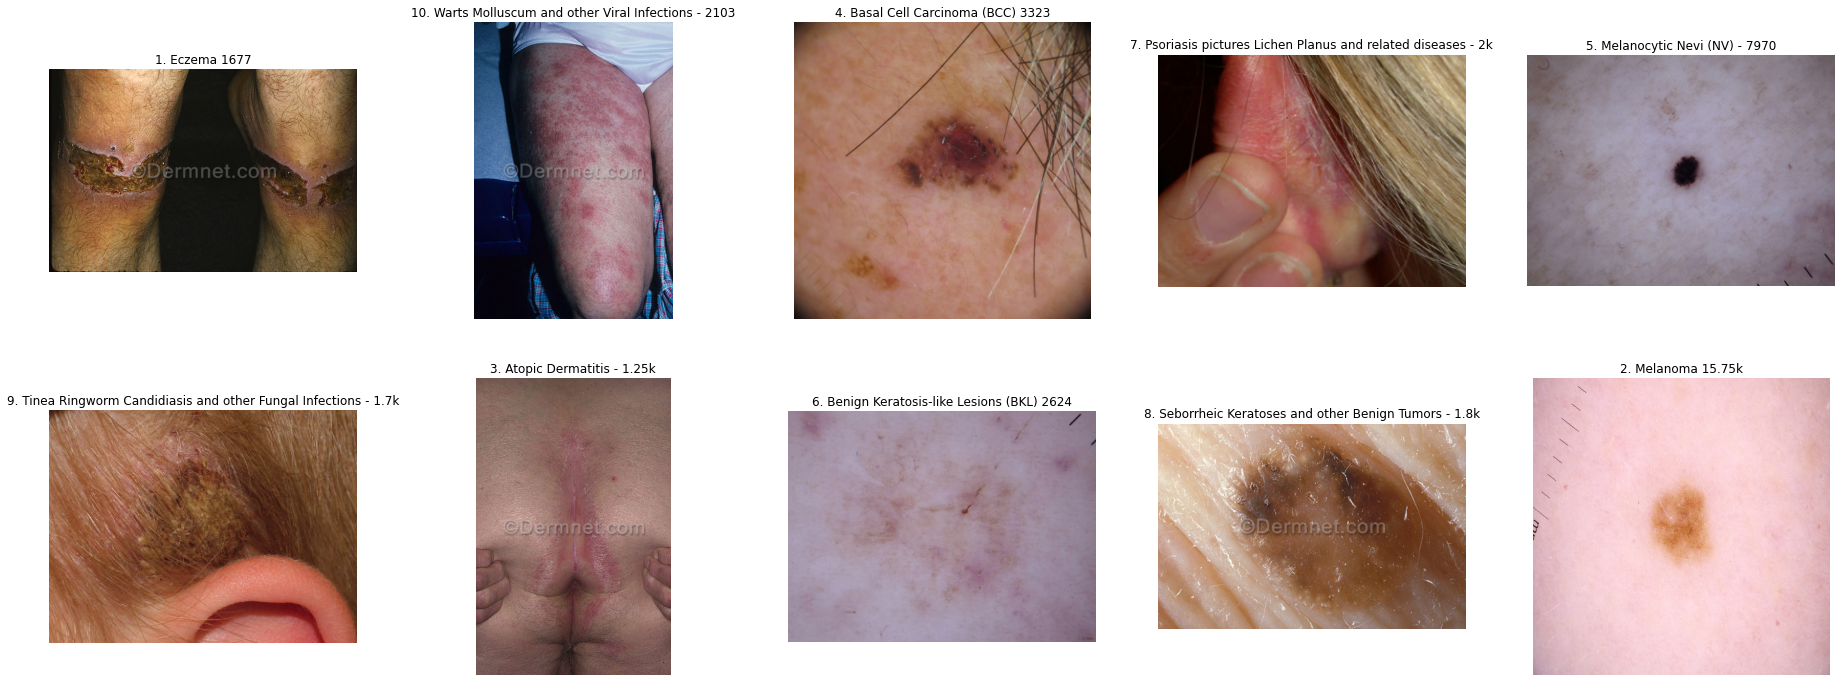

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

# Read in the data
# Set the path to the Images
data_folder = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"

# Get the class names
classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(32, 12))
i = 0
for sub_dir in os.listdir(data_folder):
    i+=1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(2, int(len(classes)/2),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(sub_dir)
plt.show()

### Prepare and Preprocess the data
Technically, this can be considered the data cleaning aspect of the Machine Learning Pipeline workflow. We want to apply some techniques on the image dataset to make the training process much more smoother and allows for higher accuracy or better model understanding/predictions. Here we can utilize normaliztion of the feature values as we want the the pixel values to be between 0 and 1 instead of 0 and 255. Additionally, we will need to split our dataset into train and test datasets. We will also need to perform one-hot encoding on the labels.

Note We have already take care of class imbalance...

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_dir = "./output/train"
val_dir = "./output/val"

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255)

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical")
#     subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical")
#     subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 10000 images belonging to 10 classes.
Preparing validation dataset...
Found 2500 images belonging to 10 classes.
class names:  ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']
Data generators ready


### Prepare Base Model
We will be using resnet, a pre-trained CNN model and applying it to our multi-classification of Skin Diseases Problem

In [65]:
# ImageNet
base_model = keras.applications.densenet.DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))
print(base_model.summary())

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_18[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

### Create our Neural Network Prediction Layers

In [66]:
from tensorflow.keras import applications
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# base_model.trainable = True

# Fine Tune
# Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
# fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False



# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

# inputs = Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = Dropout(0.2)(x)
# x = Flatten()(x)
# prediction_layer = Dense(len(classnames), activation='softmax')(x)
# outputs = prediction_layer(x)
# model = Model(inputs, outputs)

# Create prediction layer for classification of our images
x = base_model.output
# Adding a Dropout later to prevent overfitting
x = Dropout(0.2)(x)
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=SGD(learning_rate = 0.001, momentum = 0.9), # Changing the learning rate
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_18[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

### Train the Model

In [67]:
# Training Process
num_epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/10
312/312 [==============================] - 160s 396ms/step - loss: 7.4100 - accuracy: 0.4558 - val_loss: 7.4281 - val_accuracy: 0.5220
Epoch 2/10
312/312 [==============================] - 119s 381ms/step - loss: 5.2617 - accuracy: 0.6119 - val_loss: 6.7076 - val_accuracy: 0.5585
Epoch 3/10
312/312 [==============================] - 122s 391ms/step - loss: 3.8003 - accuracy: 0.6837 - val_loss: 6.8763 - val_accuracy: 0.5497
Epoch 4/10
312/312 [==============================] - 121s 387ms/step - loss: 2.9689 - accuracy: 0.7272 - val_loss: 6.6208 - val_accuracy: 0.5781
Epoch 5/10
312/312 [==============================] - 121s 388ms/step - loss: 2.4408 - accuracy: 0.7664 - val_loss: 7.5089 - val_accuracy: 0.5613
Epoch 6/10
312/312 [==============================] - 120s 384ms/step - loss: 2.0437 - accuracy: 0.7950 - val_loss: 6.4684 - val_accuracy: 0.5938
Epoch 7/10
312/312 [==============================] - 120s 383ms/step - loss: 1.9603 - accuracy: 0.8078 - val_loss: 7.1148 -

### View Loss History


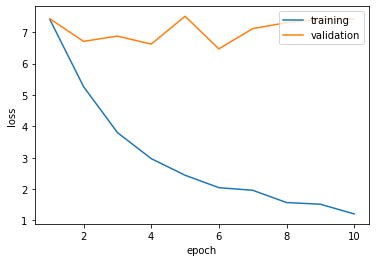

In [68]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Evaluating Model Performance
Utilize a confusion matrix to get a more detailed-analysis in Model Performance

Generating predictions from validation data...


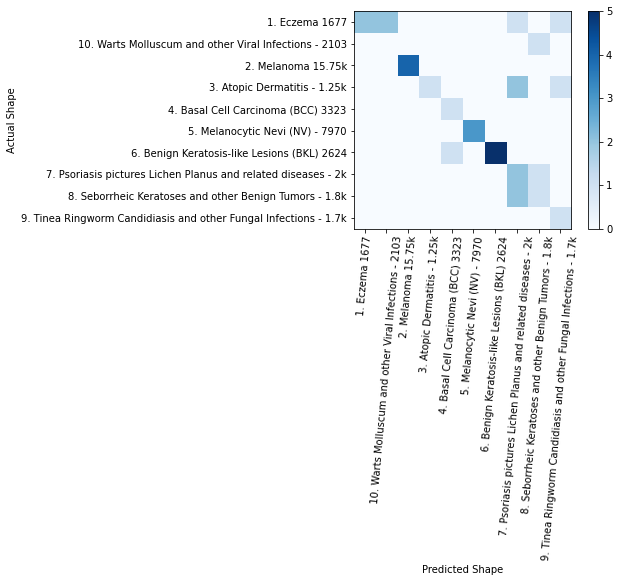

In [69]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0,...], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

### Save your model
We can save our model and reuse it later to make predictions on never seen-before data

In [ ]:
# Code to save your model
modelFileName = 'models/skin_disease_classifier_ver1.0.h5'
model.save(modelFileName)
del model
print('Model saved as', modelFileName)

### Utilized the saved Model
We can now use our pre-trained model to make predictions on new test data 

In [ ]:
# Hyperparameter Tuning (learning rate, batch size, optimizer, epochs, img size, layers)
# Gridsearch (2)
# Transfer Learning(ResNet, DenseNet) ~
# Data Augumentation/Cleaning (1)
# Remove Poisonous Data Samples (3)